# Aggregating Slice Results

In this report, I will explore different ways of aggregating slice classification results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook already uses the optimization methods tested in `3.2 - pureVsConservative`:

 - resize before augmentations 
 - pure lowest validation loss value model choice

In [24]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import copy
import os
import re



# ------------ Utils ------------

from aggregateUtils import * 

# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
from torchsummary import summary
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

In [2]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [3]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')

In [4]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


In [16]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

## Training

In [13]:
def trainResNet(train_dataset, val_dataset, num_epochs=90, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return best_model_pure, epoch_pure, loss_array, val_loss_array

In [17]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

In [18]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read from images
    pass

    
else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


Epoch [1/90], Train loss: 0.753463
Validation loss: 0.756661


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.41it/s]


Epoch [2/90], Train loss: 0.723007
Validation loss: 0.739000


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [3/90], Train loss: 0.698312
Validation loss: 0.723169


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [4/90], Train loss: 0.677297
Validation loss: 0.707858


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [5/90], Train loss: 0.655967
Validation loss: 0.693338


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [6/90], Train loss: 0.636099
Validation loss: 0.679677


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [7/90], Train loss: 0.619216
Validation loss: 0.666608


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [8/90], Train loss: 0.602873
Validation loss: 0.653919


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [9/90], Train loss: 0.584164
Validation loss: 0.641757


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [10/90], Train loss: 0.569866
Validation loss: 0.630161


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [11/90], Train loss: 0.553736
Validation loss: 0.618901


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [12/90], Train loss: 0.534811
Validation loss: 0.608119


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [13/90], Train loss: 0.523133
Validation loss: 0.597855


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [14/90], Train loss: 0.504935
Validation loss: 0.587506


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [15/90], Train loss: 0.497503
Validation loss: 0.577677


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [16/90], Train loss: 0.480808
Validation loss: 0.568311


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [17/90], Train loss: 0.465628
Validation loss: 0.559331


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [18/90], Train loss: 0.457584
Validation loss: 0.550745


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [19/90], Train loss: 0.443836
Validation loss: 0.542212


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [20/90], Train loss: 0.433135
Validation loss: 0.534030


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [21/90], Train loss: 0.422538
Validation loss: 0.526265


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [22/90], Train loss: 0.411349
Validation loss: 0.518724


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [23/90], Train loss: 0.405325
Validation loss: 0.511822


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [24/90], Train loss: 0.389632
Validation loss: 0.505656


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [25/90], Train loss: 0.385034
Validation loss: 0.499299


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [26/90], Train loss: 0.374167
Validation loss: 0.492792


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [27/90], Train loss: 0.362210
Validation loss: 0.486517


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [28/90], Train loss: 0.355164
Validation loss: 0.480906


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.37it/s]


Epoch [29/90], Train loss: 0.348617
Validation loss: 0.475115


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


Epoch [30/90], Train loss: 0.341426
Validation loss: 0.469466


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.40it/s]


Epoch [31/90], Train loss: 0.332706
Validation loss: 0.464144


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.38it/s]


Epoch [32/90], Train loss: 0.324387
Validation loss: 0.458604


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [33/90], Train loss: 0.319977
Validation loss: 0.453931


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [34/90], Train loss: 0.312000
Validation loss: 0.448902


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [35/90], Train loss: 0.304367
Validation loss: 0.444373


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.40it/s]


Epoch [36/90], Train loss: 0.296151
Validation loss: 0.439879


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.41it/s]


Epoch [37/90], Train loss: 0.291656
Validation loss: 0.435487


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [38/90], Train loss: 0.283719
Validation loss: 0.431223


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.38it/s]


Epoch [39/90], Train loss: 0.278563
Validation loss: 0.427543


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


Epoch [40/90], Train loss: 0.270081
Validation loss: 0.423945


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.17it/s]


Epoch [41/90], Train loss: 0.266523
Validation loss: 0.420446


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.17it/s]


Epoch [42/90], Train loss: 0.262157
Validation loss: 0.416646


Training...: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]


Epoch [43/90], Train loss: 0.257118
Validation loss: 0.413429


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [44/90], Train loss: 0.246162
Validation loss: 0.410603


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.35it/s]


Epoch [45/90], Train loss: 0.244478
Validation loss: 0.407479


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.37it/s]


Epoch [46/90], Train loss: 0.241723
Validation loss: 0.404404


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.41it/s]


Epoch [47/90], Train loss: 0.238634
Validation loss: 0.401491


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [48/90], Train loss: 0.233579
Validation loss: 0.398582


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [49/90], Train loss: 0.229131
Validation loss: 0.395735


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [50/90], Train loss: 0.227354
Validation loss: 0.393796


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [51/90], Train loss: 0.217397
Validation loss: 0.391286


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [52/90], Train loss: 0.216814
Validation loss: 0.389012


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [53/90], Train loss: 0.210481
Validation loss: 0.386463


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [54/90], Train loss: 0.201803
Validation loss: 0.384423


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [55/90], Train loss: 0.205688
Validation loss: 0.382333


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [56/90], Train loss: 0.197191
Validation loss: 0.380214


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.39it/s]


Epoch [57/90], Train loss: 0.198366
Validation loss: 0.378636


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.38it/s]


Epoch [58/90], Train loss: 0.192310
Validation loss: 0.376757


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [59/90], Train loss: 0.196924
Validation loss: 0.375565


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [60/90], Train loss: 0.187467
Validation loss: 0.373880


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [61/90], Train loss: 0.184986
Validation loss: 0.372893


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [62/90], Train loss: 0.179276
Validation loss: 0.371456


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [63/90], Train loss: 0.175467
Validation loss: 0.370445


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [64/90], Train loss: 0.169949
Validation loss: 0.368860


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [65/90], Train loss: 0.164292
Validation loss: 0.367903


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [66/90], Train loss: 0.172254
Validation loss: 0.366683


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [67/90], Train loss: 0.164628
Validation loss: 0.365720


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [68/90], Train loss: 0.162000
Validation loss: 0.364767


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.50it/s]


Epoch [69/90], Train loss: 0.161643
Validation loss: 0.363213


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [70/90], Train loss: 0.158931
Validation loss: 0.362221


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [71/90], Train loss: 0.157460
Validation loss: 0.361350


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [72/90], Train loss: 0.148641
Validation loss: 0.360757


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [73/90], Train loss: 0.149947
Validation loss: 0.360019


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [74/90], Train loss: 0.139645
Validation loss: 0.359474


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [75/90], Train loss: 0.138915
Validation loss: 0.359094


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.49it/s]


Epoch [76/90], Train loss: 0.139147
Validation loss: 0.358314


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [77/90], Train loss: 0.135299
Validation loss: 0.357409


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


Epoch [78/90], Train loss: 0.133262
Validation loss: 0.356823


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [79/90], Train loss: 0.132036
Validation loss: 0.356728


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [80/90], Train loss: 0.133547
Validation loss: 0.355952


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [81/90], Train loss: 0.128165
Validation loss: 0.355303


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.47it/s]


Epoch [82/90], Train loss: 0.128107
Validation loss: 0.355151


Training...: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [83/90], Train loss: 0.125728
Validation loss: 0.355246


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.44it/s]


Epoch [84/90], Train loss: 0.125155
Validation loss: 0.354529


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]


Epoch [85/90], Train loss: 0.157305
Validation loss: 0.354530


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.36it/s]


Epoch [86/90], Train loss: 0.120046
Validation loss: 0.354548


Training...: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


Epoch [87/90], Train loss: 0.118028
Validation loss: 0.354021


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.43it/s]


Epoch [88/90], Train loss: 0.116769
Validation loss: 0.353846


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.42it/s]


Epoch [89/90], Train loss: 0.121810
Validation loss: 0.353581


Training...: 100%|██████████| 55/55 [00:22<00:00,  2.41it/s]


Epoch [90/90], Train loss: 0.107191
Validation loss: 0.353046


In [19]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'model_state_dict': resnet_eval.state_dict(),
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'resnet_aggregate.pt'))

else: print("DID NOT SAVE")

# Results and Aggregation Methods

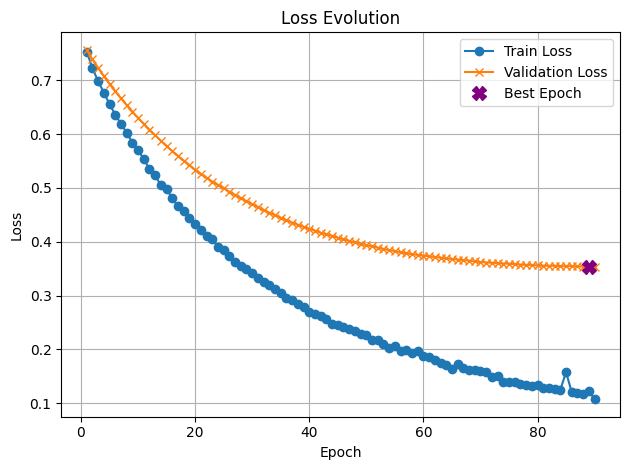

Best Validation Loss:  0.3530456679207938


In [21]:
plotLoss(custom_loss, custom_val_loss, best_epoch)
print("Best Validation Loss: ",custom_val_loss[best_epoch])

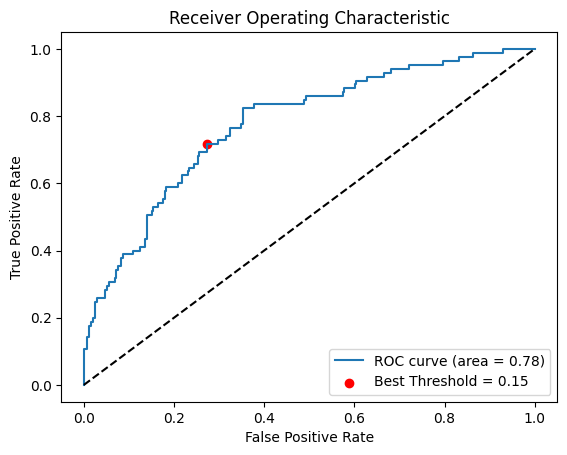

Area Under Curve: 0.7763661059450424
Best Threshold (closest to (0,1)): 0.15306047


In [22]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

In [26]:
def evalResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [27]:
evalResNet(resnet_eval, test_dataset,threshold_eval,auc_eval)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 72.65%  (409 in 563)
Accuracy for Class 1: 71.76%  (61 in 85)
Test Accuracy: 72.53%
Weighted Accuracy: 71.88%

 --------------------- 

Area Under Curve: 0.7763661059450424

 --------------------- 

F1 Score (Macro): 0.614
F1 Score (Weighted): 0.767
F1 Score Class 0: 0.821
F1 Score Class 1: 0.407

 --------------------- 


Confusion Matrix: 
 [[409 154]
 [ 24  61]]


## Patient-wise Classification

This will be done through aggregation of the probabilities determined by the resnet for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of probabilities. 
 - another dictionary containing the same keys, but with binary classification value arrays.

In [ ]:
def getPatientID(s):
    # HRCT_Pilot__PatientID
    match = re.search(r'HRCT_Pilot__(\d+)__', s)
    if match: return match.group(1)
        
    # PatientID__sliceSpecific
    match = re.match(r'(\d+)__', s)
    if match:
        return match.group(1)
    return None  

In [ ]:
def evalPatientResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)